In [49]:
import os
import time
import pickle
import keyboard
import numpy as np
import random
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import tminterface as tmi
from tminterface.interface import TMInterface, Client

# Useful functions

In [55]:
def discrete_to_continuous(n):

    """
    Equivalents:
    
    0: no action
    1: left
    2: left + acceleration
    3: acceleration
    4: right + acceleration
    5: right
    """

    current_action = {
    'sim_clear_buffer': True,  
    "steer":           0,
    "accelerate":      False, 
    "brake" :          False
    }
    
    if n == 1:
        current_action["steer"] = -65536
    if n == 2:
        current_action["steer"] = -65536
        current_action["accelerate"] = True
    if n == 3:
        current_action["accelerate"] = True
    if n == 4:
        current_action["steer"] = 65536
        current_action["accelerate"] = True
    if n == 5:
        current_action["steer"] = 65536
        
    return current_action
    

def distance_3D(x, y, z, x0, y0, z0):
    d_x = x - x0
    d_y = y - y0
    d_z = z - z0
    dis = np.sqrt( d_x**2 + d_y**2 + d_z**2)
    return dis

# Abstract Client

In [32]:
class AbstractClient(Client):

    def __init__(self):
        super().__init__()
        self.dna = None
        self.period = 1.0
        self.period_ms = np.floor(1000*self.period)
        self.final_state = None
        self.start_state = None
        self.is_finish = False
        self.finish_dna = None
        self.crashed = False
        
    def on_registered(self, iface: TMInterface) -> None:
        iface.execute_command("press delete")
        print(f'Registered to {iface.server_name}')

    def on_run_step(self, iface, _time: int):
        self.action(iface, _time)

    def on_checkpoint_count_changed(self, iface, current: int, target: int):
        if current >= 1 and current == target:
            self.is_finish = True
            self.finish_dna = self.dna.copy()

    def reset_detection(self, _time, state):
        if state.position[1] < 9.2:
            return True
    
        if _time >= 500:
            local_velocity = state.scene_mobil.current_local_speed
            local_velocity = np.array(list(local_velocity.to_numpy()))
            local_velocity = local_velocity*3.6 
            if local_velocity[2] < 1:
                return True

        if state.scene_mobil.has_any_lateral_contact:
            return True

        return False

    def action(self, iface, _time: int):
        if _time >= 0 and _time < len(self.dna)*self.period_ms:
            
            action = self.dna[int(np.floor(_time/self.period_ms))]
            command = discrete_to_continuous(action)
            iface.set_input_state(**command)

            if self.reset_detection(_time, iface.get_simulation_state()):
                self.crashed = True
                self.finish(iface, _time)
            else: 
                self.crashed = False
                
        if _time == len(self.dna)*self.period_ms:
            self.finish(iface, _time)

    def finish(self, iface,  _time):
        self.final_state = iface.get_simulation_state()
        iface.rewind_to_state(self.start_state)

# Training Client and Replay Client

In [33]:
class TrainingClient(AbstractClient):

    def __init__(self, period=0.5, n_trials=200):
        super().__init__()
        # DNA = memory + gene
        self.memory = np.array([])
        self.past_tries = [[]]
        self.gene = None
        self.generate_dna()
        self.period = period
        self.period_ms = np.floor(1000*self.period)
        self.max_trials = n_trials
        self.n_trial = 1

        self.best_gene = self.gene
        self.best_perf = 0
        self.anchor = 0

    def generate_dna(self):
        if self.gene is not None:
            self.past_tries.append(list(self.gene))
        self.gene = np.random.randint(low=1, high=6, size=5)
        while list(self.gene) in self.past_tries:
            self.gene = np.random.randint(low=1, high=6, size=5)
        self.dna = np.concatenate([self.memory, self.gene])

    def on_run_step(self, iface, _time: int):
        self.action(iface, _time)
        if _time == self.anchor:
            self.start_state = iface.get_simulation_state()
            
    def finish(self, iface, _time):
        self.n_trial += 1
        self.final_state = iface.get_simulation_state()

        # OBECTIVE FUNCTION CONDITION
        if self.final_state.position[0] > self.best_perf and self.crashed is False:
            self.best_gene = self.gene
            self.best_perf = self.final_state.position[0]

        if self.n_trial == self.max_trials:
            if self.best_gene is not None:
                self.memory = np.concatenate([self.memory, self.best_gene[:1]])
                self.anchor += self.period_ms
                print(self.memory)
                
            self.n_trial = 0
            self.past_tries = [[]]
            self.best_perf = 0
            self.best_gene = None
        
        iface.rewind_to_state(self.start_state)
        self.generate_dna()
        
class ReplayClient(AbstractClient):

    def __init__(self, period, dna):
        super().__init__()
        self.period = period
        self.period_ms = np.floor(1000*self.period)
        self.dna = dna
        self.replay = []

    def on_run_step(self, iface, _time: int):
        self.action(iface, _time)
        if _time == 0:
            self.start_state = iface.get_simulation_state()
        self.replay.append(_time)
        self.expensive_computation()
        
    def finish(self, iface, _time):
        self.final_state = iface.get_simulation_state()
        print(self.final_state.position)
        iface.rewind_to_state(self.start_state)

    def expensive_computation(self):
        i = 0
        for i in range(2):
            i += 1

# Create Centerline Function

In [53]:
def centerline_objective(track_name):
    run_folder = "track_data/"+ track_name + "/run-1"
    positions = pickle.load(open(os.path.join(run_folder, "positions.pkl"), "rb"))
    finish_time = positions[-1]["time"]/1000

    raw_points = [list(pos['position'].to_numpy()) for pos in positions]
    df = pd.DataFrame(raw_points)
    ema = df.ewm(com=40).mean()
    raw_points = ema.values.tolist()
        
    # remove duplicates:
    points = [raw_points[0]]
    for point in raw_points[1:]:
        if point != points[-1]:
            points.append(point)
        else:
            for i in range(len(point)):
                point[i] += 0.01
            points.append(point)
    points = np.array(points)

    # Time along the track:
    time = np.linspace(0, 1, len(points))

    interpolator =  interp1d(time, points, kind='slinear', axis=0)
    alpha = np.linspace(0, 1, len(points))
    curve = interpolator(alpha)

    return curve

## Training Client

In [34]:
interface = TMInterface()
client = TrainingClient(period= 0.5, n_trials=10)

interface.register(client)
print("Start")

while client.is_finish is False:
    time.sleep(0.001)

    if keyboard.is_pressed("q"):
        print("Keybord Interrupt")
        break

if client.is_finish:
    best_memory = client.memory + client.finish_dna
else:
    best_memory = client.memory

interface.close()
best_dna = client.memory
print(best_dna)

Start
Registered to TMInterface0
[4.]
[4. 3.]
[4. 3. 1.]
[4. 3. 1. 4.]
[4. 3. 1. 4. 2.]
[4. 3. 1. 4. 2. 3.]
Keybord Interrupt
[4. 3. 1. 4. 2. 3.]


## Replay Client

In [29]:
interface = TMInterface()

best_memory = np.array([2., 3., 4., 3., 2., 2., 4., 2., 3., 3., 3., 5., 4., 4., 3., 4., 2.,
       5., 5., 2., 1., 2., 2., 2., 3., 3., 4., 4., 5., 4., 3., 4., 1., 1.,
       2., 5., 3., 1., 2., 4., 2., 2., 3., 4.])

client = ReplayClient(period= 0.5, dna=best_memory)

interface.register(client)
print("Start")

while True:
    time.sleep(0.001)

    if keyboard.is_pressed("q"):
        print("Keybord Interrupt")
        break

interface.close()

Start
Registered to TMInterface0
[633.0264282226562, 9.385685920715332, 461.2616882324219]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.384660720825195, 464.5208435058594]
[286.19146728515625, 9.3

# Testing

2213


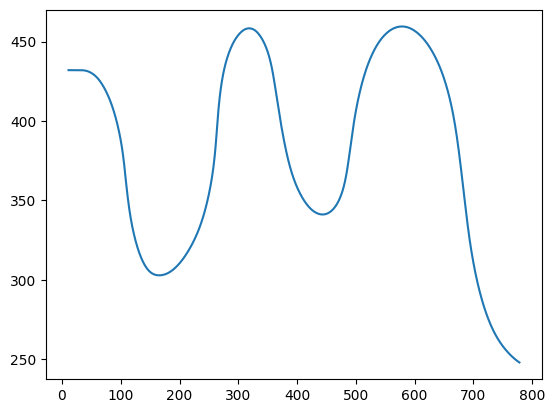

In [54]:
curve = centerline_objective("Deterministic_Proof")
print(len(curve))
plt.plot(*curve[:, [0, 2]].T, '-');

In [ ]:
run_folder = "track_data/Determinstic_Proof/run-1"
positions = pickle.load(open(os.path.join(run_folder, "positions.pkl"), "rb"))